### Description:
This is the model that Jacob implemented in file model_03_qrc_esn_v2_7. 

**V.01**
1. I added two grid search nets, one that moddifies the data structure generated by the Mackey-Glass function and the second one that that optimizes the hyperparameters of the RC.
2. I tested 4 different Mackey-Glass generation sets: 
3. Technical aspect: I added a new library (joblib) that lets you use all the cores of your CPU for the grid search process (which is parallel)

**V.02**
1. I translated the code to english for clarity
2. As Jacob suggested I added 11 sub-seeds and every grid-search loop goes through all of them and selects the median score for comparison.
3. I also added the PCA analysis that shows how many "real" demensions are inserted inside our ridge regression model
4. The results are saved in a more well-organized way

**V.03**
1. I added the standard deviation and coefficient of variation to measure how big is the difference between the 11 different initializations (sub-seeds)
2. I added NARMA 10 data-set that Dominika suggested, it should have lower leakage rate values as it is more dependant on the past values of the data.
3. Some slight modifications to the graphs
4. In an additional file "grid_search_hp_03_02.ipynb" I added an experimental QRC-ESN model. 

### Observations:

**V.01**
1. For every M-G data the best output based on MSE was for the following hp: \
leakage_rate                         0.99 \
window_size                             6 \
n_layers                                3 
2. At first the code was running very slowly but the multi core solution works much better (on my machine). 
3. The model works perfectly for one-step-ahead prediction for the different tested M-G data sets. 



**V.02**
1. The additional seeds did not change the result signifficantly but improved the statistical relliability of the results.
2. The PCA analysis showed nicely that the "real" dimensionality of the outputs of the QRC-ESN model is a lot smaller than the "theoretical" dimensionality. 
3. When comparing the worst model and the best model (worst combination and best combination of hyperparameters according to MSE) for all the data sets the "worse" model has lower "real" dimensionality in comparison to the "better" one. 

**V.03**
1. The coefficient of variation showed high values for some data-sets. That shows that our 11 sub-seed implementation is necessary.
2. The NARMA data-set shows even higher dimensions in the PCA analysis (6 dimensions for 95% of variance of the ridge regression)
3. The NARMA data-set showed smaller optimal leakage rates that which shows that our model is working properly just the M-G data-set requires almost no memory.

In [35]:
# !pip install joblib

In [36]:
# === Step 1: Import necessary libraries ===
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from tqdm.notebook import tqdm # To visualize loop progress
# NEW: Import joblib for parallel processing
from joblib import Parallel, delayed
from scipy.signal import lfilter

print("Libraries imported successfully.")

Libraries imported successfully.


In [37]:
# === Step 2: Prepare the data ===
def mackey_glass(beta=0.2, gamma=0.1, n=10, tau=30, dt=1.0, T=2000):
    """
    Simulates the Mackey-Glass time series.
    Returns values scaled to the interval [0, 1].
    """
    N = int(T / dt)
    delay_steps = int(tau / dt)
    x = np.zeros(N + delay_steps)
    x[0:delay_steps] = 1.2
    
    for t in range(delay_steps - 1, N + delay_steps - 1):
        x_tau = x[t - delay_steps]
        dxdt = (beta * x_tau / (1 + x_tau**n)) - (gamma * x[t])
        x[t+1] = x[t] + dxdt * dt

    # Scale to [0, 1]
    x_series = x[delay_steps:]
    x_min, x_max = np.min(x_series), np.max(x_series)
    x_scaled = (x_series - x_min) / (x_max - x_min)
    
    return x_scaled

def create_io_pairs(data, window_size, lag=0):
    """
    Creates input-output pairs from a time series, considering a lag.
    Args:
        data (np.array): The time series.
        window_size (int): The length of the input window.
        lag (int): The shift of the window into the past.
    """
    inputs = []
    outputs = []
    
    for i in range(len(data) - window_size - lag):
        input_window = data[i : i + window_size]
        inputs.append(input_window)
        output_point = data[i + window_size + lag]
        outputs.append(output_point)
        
    return np.array(inputs), np.array(outputs)

def generate_arma_data(n_points=1000, ar_coeffs=[1, -0.7], ma_coeffs=[1, 0.5, -0.3], seed=42):
    """
    Generates time series data from an ARMA(p,q) process.
    Returns values scaled to the interval [0, 1].
    """
    np.random.seed(seed)
    
    # Generate noise
    noise = np.random.normal(0, 1, n_points)
    
    # Generate ARMA data using a linear filter
    data = lfilter(ma_coeffs, ar_coeffs, noise)
    
    # Scale to [0, 1] for consistency with the Mackey-Glass generator
    data_min = np.min(data)
    data_max = np.max(data)
    data_scaled = (data - data_min) / (data_max - data_min)
    
    return data_scaled

def generate_narma_data(n_points=2000, order=10, 
                        alpha=0.3, beta=0.05, gamma=1.5, delta=0.1, 
                        seed=42):
    """
    Generates time series data from a NARMA (Nonlinear AutoRegressive Moving Average) process.
    Specifically, this implements the standard NARMA10 task when order=10.

    Args:
        n_points (int): The total number of points in the time series.
        order (int): The memory order of the system (e.g., 10 for NARMA10).
        alpha, beta, gamma, delta (float): Coefficients of the NARMA equation.
        seed (int): Seed for the random number generator for reproducibility.

    Returns:
        np.array: The generated NARMA time series, scaled to the interval [0, 1].
    """
    # Set the seed for the random input signal
    np.random.seed(seed)
    
    # Generate a random input signal s(t) uniformly distributed in [0, 0.5]
    s = np.random.uniform(0, 0.5, n_points)
    
    # Initialize the output array y
    y = np.zeros(n_points)
    
    # Iterate to generate the time series based on the NARMA equation
    for k in range(order, n_points):
        # The equation for the NARMA10 task
        sum_term = np.sum(y[k-order:k])
        
        y[k] = (alpha * y[k-1] + 
                beta * y[k-1] * sum_term + 
                gamma * s[k-order] * s[k] + 
                delta)

    # Scale the output to the [0, 1] interval for consistency
    y_min = np.min(y)
    y_max = np.max(y)
    y_scaled = (y - y_min) / (y_max - y_min)
    
    return y_scaled

In [38]:
# === Step 3: Define the QRC-ESN model (Corrected) ===

# MODIFICATION: Removed 'seed' argument from the function definition
def get_q_device(n_qubits):
    """Creates a PennyLane quantum device."""
    # MODIFICATION: Removed 'seed=seed' from the device call
    return qml.device("default.qubit", wires=n_qubits, shots=None)

def quantum_feature_map(inputs, weights, biases, n_layers, n_qubits, dev):
    """The quantum circuit acting as a feature map."""
    @qml.qnode(dev)
    def circuit(inputs, weights, biases):
        for i in range(n_qubits):
            total_angle = inputs[i] + biases[i]
            qml.RX(total_angle, wires=i)

        for layer in range(n_layers):
            for i in range(n_qubits):
                qml.Rot(*weights[layer, i], wires=i)
            for i in range(n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
                
        observables = [qml.expval(qml.PauliX(i)) for i in range(n_qubits)] + \
                      [qml.expval(qml.PauliY(i)) for i in range(n_qubits)] + \
                      [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
        return observables

    return circuit(inputs, weights, biases)

def train_esn_reservoir(train_inputs, train_outputs, n_layers, n_qubits, leakage_rate, lambda_reg, seed):
    """
    Trains the quantum reservoir.
    MODIFIED: Now also returns the generated quantum_features matrix for analysis.
    """
    np.random.seed(seed)
    weights = np.random.uniform(-np.pi, np.pi, (n_layers, n_qubits, 3))
    biases = np.random.uniform(-0.5, 0.5, n_qubits)
    
    n_observables = 3 * n_qubits
    n_samples = len(train_inputs)
    dev = get_q_device(n_qubits)

    # 1. Compute classical ESN states
    classical_states = np.zeros((n_samples, n_qubits))
    current_classical_state = np.zeros(n_qubits)
    for t in range(n_samples):
        current_classical_state = (1 - leakage_rate) * current_classical_state + leakage_rate * train_inputs[t]
        classical_states[t] = current_classical_state

    # 2. Map classical states to quantum features
    quantum_features = np.zeros((n_samples, n_observables))
    for t in range(n_samples):
        quantum_features[t] = quantum_feature_map(
            inputs=classical_states[t], weights=weights, biases=biases,
            n_layers=n_layers, n_qubits=n_qubits, dev=dev
        )

    # 3. Train the readout layer (Ridge Regression)
    R = quantum_features
    Y = train_outputs.reshape(-1, 1)
    I = np.identity(n_observables)
    W_out = np.linalg.solve(R.T @ R + lambda_reg * I, R.T @ Y).flatten()
    
    # MODIFICATION: Return the quantum_features matrix as well
    return W_out, weights, biases, quantum_features

# Prediction function for "one-step-ahead"
def predict_esn(test_inputs, weights, biases, W_out, n_layers, n_qubits, leakage_rate, seed):
    """Makes predictions step-by-step using true input data."""
    predictions = []
    current_classical_state = np.zeros(n_qubits)
    # MODIFICATION: Call get_q_device without the seed
    dev = get_q_device(n_qubits)
    
    for input_val in test_inputs:
        current_classical_state = (1 - leakage_rate) * current_classical_state + leakage_rate * input_val
        q_features = quantum_feature_map(
            inputs=current_classical_state, weights=weights, biases=biases,
            n_layers=n_layers, n_qubits=n_qubits, dev=dev)
        y_pred = np.dot(W_out, q_features)
        predictions.append(y_pred)
        
    return np.array(predictions)

# Prediction function for "autonomous" mode
def predict_esn_autonomous(initial_window, prediction_length, weights, biases, W_out, n_layers, n_qubits, leakage_rate, seed):
    """Makes predictions autonomously, where the model's output is fed back as input."""
    predictions = []
    current_classical_state = np.zeros(n_qubits)
    # MODIFICATION: Call get_q_device without the seed
    dev = get_q_device(n_qubits)

    current_classical_state = (1 - leakage_rate) * current_classical_state + leakage_rate * initial_window
    current_window = initial_window.copy()

    for _ in range(prediction_length):
        q_features = quantum_feature_map(
            inputs=current_classical_state, weights=weights, biases=biases,
            n_layers=n_layers, n_qubits=n_qubits, dev=dev)
        y_pred = np.dot(W_out, q_features)
        predictions.append(y_pred)
        current_window = np.append(current_window[1:], y_pred)
        current_classical_state = (1 - leakage_rate) * current_classical_state + leakage_rate * current_window

    return np.array(predictions)

In [39]:
# === Step 4: Define data profiles and hyperparameter grid ===
# Data profiles based on the report
data_profiles = [
    # {'name': 'Classic_Chaos_(tau=17)', 
    #  'generator': mackey_glass,
    #  'params': {'beta': 0.2, 'gamma': 0.1, 'n': 10, 'tau': 17, 'dt': 1.0, 'T': 2000}}
    #  ,
     
    {'name': 'Complex_Chaos_(tau=30)',
     'generator': mackey_glass,
     'params': {'beta': 0.2, 'gamma': 0.1, 'n': 10, 'tau': 30, 'dt': 1.0, 'T': 2000}},
     
    {'name': 'Hyperchaotic_(tau=100)',
     'generator': mackey_glass,
     'params': {'beta': 0.2, 'gamma': 0.1, 'n': 10, 'tau': 100, 'dt': 1.0, 'T': 2000}}
     ,
     
    # NEW PROFILE FOR ARMA DATA
    {'name': 'ARMA_1_2_stochastic',
     'generator': generate_arma_data,
     'params': {'n_points': 2000, 'ar_coeffs': [1, -0.7], 'ma_coeffs': [1, 0.5, -0.3]}}
    ,
    {'name': 'NARMA10_Chaotic',
      'generator': generate_narma_data,
      'params': {'n_points': 2000, 'order': 10} 
        # Default coefficients for the standard NARMA10 task will be used
    }
]

# Hyperparameter grid for testing
param_grid = {
    'leakage_rate': [0.1, 0.3, 0.5, 0.7, 0.9],
    'lambda_reg': [1e-8],
    'window_size': [6, 8, 10],
    'n_layers': [1, 2, 3],
    'lag': [0]
}

In [40]:
# === Step 5: Corrected run_single_experiment function ===

def run_single_experiment(params, profile, time_series, train_fraction, main_seed, num_inits=11):
    """
    Runs a single experiment with multiple initializations and returns a full statistical summary
    of the MSE scores to evaluate model stability, including the Coefficient of Variation (CV).
    """
    leakage, lambda_r, win_size, layers, lag = params

    current_params = {
        'data_profile': profile['name'],
        'leakage_rate': leakage,
        'lambda_reg': lambda_r,
        'window_size': win_size,
        'n_layers': layers,
        'lag': lag
    }
    data_gen_params = profile['params']
    current_params.update(data_gen_params)

    n_qubits = win_size

    train_size = int(len(time_series) * train_fraction)
    train_inputs, train_outputs = create_io_pairs(time_series[:train_size], win_size)
    test_inputs, test_outputs = create_io_pairs(time_series[train_size:], win_size)

    if len(test_inputs) == 0:
        stats_keys = ['mean', 'std', 'min', 'max', 'median', 'cv'] # Added CV
        for pred_type in ['one_step_ahead', 'autonomous']:
            for key in stats_keys:
                current_params[f'{key}_mse_{pred_type}'] = float('nan')
        return current_params

    mse_one_step_runs = []
    mse_autonomous_runs = []

    np.random.seed(main_seed)
    sub_seeds = np.random.randint(0, 100000, num_inits)

    for i in range(num_inits):
        run_seed = int(sub_seeds[i])
        W_out, weights, biases, _ = train_esn_reservoir(
            train_inputs, train_outputs, layers, n_qubits, leakage, lambda_r, run_seed
        )

        one_step_preds = predict_esn(
            test_inputs, weights, biases, W_out, layers, n_qubits, leakage, run_seed
        )
        mse_one_step_runs.append(np.mean((one_step_preds - test_outputs)**2))
        
        initial_window = train_inputs[-1]
        prediction_length = len(test_outputs)
        autonomous_preds = predict_esn_autonomous(
            initial_window, prediction_length, weights, biases, W_out,
            layers, n_qubits, leakage, run_seed
        )
        mse_autonomous_runs.append(np.mean((autonomous_preds - test_outputs)**2))

    # ===============================================================
    # UPDATED SECTION: Calculate full statistics with CV
    # ===============================================================
    if mse_one_step_runs:
        mean_mse = np.mean(mse_one_step_runs)
        std_mse = np.std(mse_one_step_runs)
        
        current_params['mean_mse_one_step_ahead'] = mean_mse
        current_params['std_mse_one_step_ahead'] = std_mse
        current_params['min_mse_one_step_ahead'] = np.min(mse_one_step_runs)
        current_params['max_mse_one_step_ahead'] = np.max(mse_one_step_runs)
        current_params['median_mse_one_step_ahead'] = np.median(mse_one_step_runs)
        
        # NEW METRIC: Coefficient of Variation (CV)
        current_params['cv_mse_one_step_ahead'] = std_mse / mean_mse if mean_mse > 0 else 0

    if mse_autonomous_runs:
        mean_mse_auto = np.mean(mse_autonomous_runs)
        std_mse_auto = np.std(mse_autonomous_runs)

        current_params['mean_mse_autonomous'] = mean_mse_auto
        current_params['std_mse_autonomous'] = std_mse_auto
        current_params['min_mse_autonomous'] = np.min(mse_autonomous_runs)
        current_params['max_mse_autonomous'] = np.max(mse_autonomous_runs)
        current_params['median_mse_autonomous'] = np.median(mse_autonomous_runs)

        # NEW METRIC: Coefficient of Variation (CV)
        current_params['cv_mse_autonomous'] = std_mse_auto / mean_mse_auto if mean_mse_auto > 0 else 0
        
    return current_params

In [41]:
# === Step 6: Main research loop ===

# A list to store all results from all profiles
all_results = []
# Percentage of data to be used for the training set
train_fraction = 0.7 
# Main seed for reproducibility of the entire experiment
seed = 2025

# Loop over each defined data profile
for profile in data_profiles:
    print(f"\n{'='*60}")
    print(f"Starting tests for data profile: {profile['name']}")
    print(f"{'='*60}")
    
    # Generate the time series for the current profile
    time_series = profile['generator'](**profile['params'])
    
    # Create all possible combinations of hyperparameters from the grid
    param_combinations = list(itertools.product(*param_grid.values()))
    
    # CORRECTION: Removed the problematic 'experiment_wrapper'.
    # joblib is designed to integrate with tqdm directly when used in a 'with' block.
    # The progress bar will now update correctly without causing a PicklingError.
    with tqdm(total=len(param_combinations), desc=f"Processing {profile['name']}") as pbar:
        profile_results = Parallel(n_jobs=-1)(
            delayed(run_single_experiment)(params, profile, time_series, train_fraction, main_seed=seed)
            for params in param_combinations
        )
        
    all_results.extend(profile_results)


Starting tests for data profile: Complex_Chaos_(tau=30)


Processing Complex_Chaos_(tau=30):   0%|          | 0/45 [00:00<?, ?it/s]


Starting tests for data profile: Hyperchaotic_(tau=100)


Processing Hyperchaotic_(tau=100):   0%|          | 0/45 [00:00<?, ?it/s]


Starting tests for data profile: ARMA_1_2_stochastic


Processing ARMA_1_2_stochastic:   0%|          | 0/45 [00:00<?, ?it/s]


Starting tests for data profile: NARMA10_Chaotic


Processing NARMA10_Chaotic:   0%|          | 0/45 [00:00<?, ?it/s]

In [42]:
# === Step 7: Analysis and saving of results ===

results_df = pd.DataFrame(all_results)

# Save the results to a CSV file
filename = 'results_median_analysis.csv'
results_df.to_csv(filename, index=False)

print(f"\n\n{'='*60}")
print("--- ALL EXPERIMENTS COMPLETED ---")
print(f"Results have been successfully saved to the file '{filename}'.")
print(f"{'='*60}")

# Display the best parameter combinations for each data type
print("\n--- Best parameters for 'One-Step-Ahead' prediction (by median MSE) ---")
best_one_step_df = results_df.loc[results_df.groupby('data_profile')['median_mse_one_step_ahead'].idxmin()]
print(best_one_step_df.to_string())

print("\n--- Best parameters for 'Autonomous' prediction (by median MSE) ---")
best_autonomous_df = results_df.loc[results_df.groupby('data_profile')['median_mse_autonomous'].idxmin()]
print(best_autonomous_df.to_string())

print("\n\nFull table of all results (sorted by best autonomous MSE globally):")
print(results_df.sort_values(by='median_mse_autonomous', ascending=True).to_string())



--- ALL EXPERIMENTS COMPLETED ---
Results have been successfully saved to the file 'results_median_analysis.csv'.

--- Best parameters for 'One-Step-Ahead' prediction (by median MSE) ---
               data_profile  leakage_rate    lambda_reg  window_size  n_layers  lag  beta  gamma     n    tau   dt       T  mean_mse_one_step_ahead  std_mse_one_step_ahead  min_mse_one_step_ahead  max_mse_one_step_ahead  median_mse_one_step_ahead  cv_mse_one_step_ahead  mean_mse_autonomous  std_mse_autonomous  min_mse_autonomous  max_mse_autonomous  median_mse_autonomous  cv_mse_autonomous  n_points  ar_coeffs       ma_coeffs  order
127     ARMA_1_2_stochastic           0.9  1.000000e-08            6         2    0   NaN    NaN   NaN    NaN  NaN     NaN                 0.008545                0.000113                0.008379                0.008693                   0.008506               0.013206             0.022960            0.000609            0.022495            0.024418               0.022583 


Preparing plots for the best configurations (based on autonomous prediction MSE)...

--- Generating plot for: ARMA_1_2_stochastic ---
Best parameters found: 
data_profile                 ARMA_1_2_stochastic
leakage_rate                                 0.9
lambda_reg                                   0.0
window_size                                    6
n_layers                                       2
lag                                            0
beta                                         NaN
gamma                                        NaN
n                                            NaN
tau                                          NaN
dt                                           NaN
T                                            NaN
mean_mse_one_step_ahead                 0.008545
std_mse_one_step_ahead                  0.000113
min_mse_one_step_ahead                  0.008379
max_mse_one_step_ahead                  0.008693
median_mse_one_step_ahead               0.008506
cv_mse_o

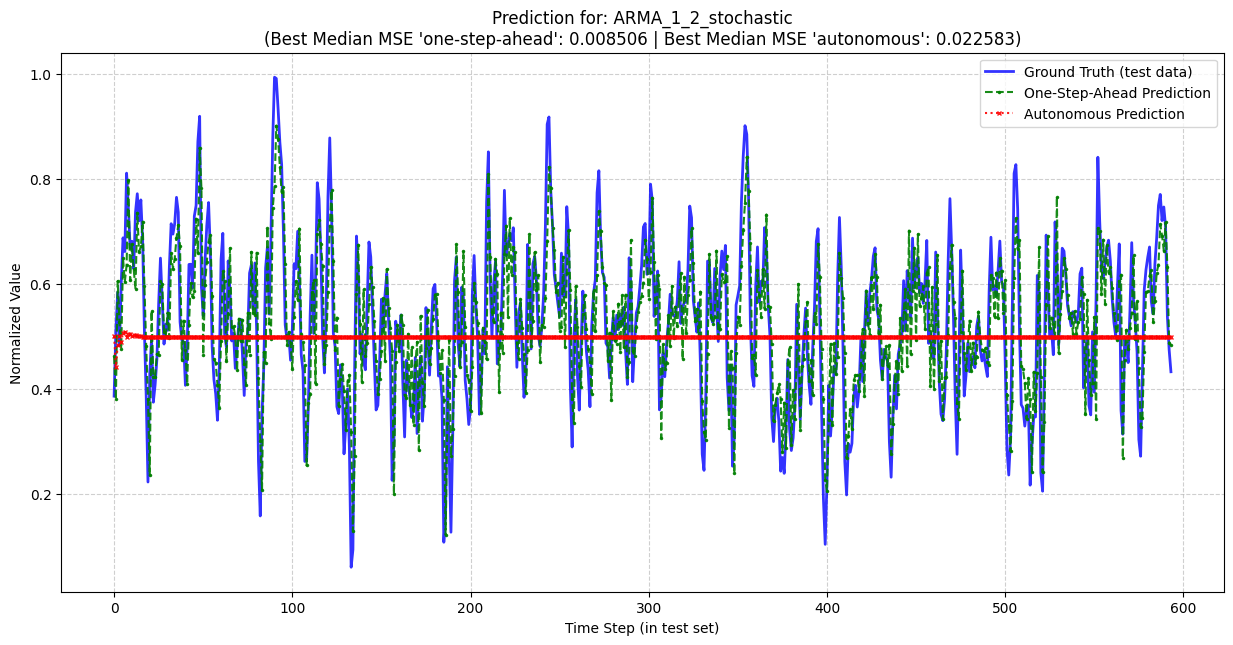


--- Generating plot for: Complex_Chaos_(tau=30) ---
Best parameters found: 
data_profile                 Complex_Chaos_(tau=30)
leakage_rate                                    0.9
lambda_reg                                      0.0
window_size                                       6
n_layers                                          3
lag                                               0
beta                                            0.2
gamma                                           0.1
n                                              10.0
tau                                            30.0
dt                                              1.0
T                                            2000.0
mean_mse_one_step_ahead                    0.000018
std_mse_one_step_ahead                     0.000006
min_mse_one_step_ahead                     0.000011
max_mse_one_step_ahead                     0.000036
median_mse_one_step_ahead                  0.000016
cv_mse_one_step_ahead                  

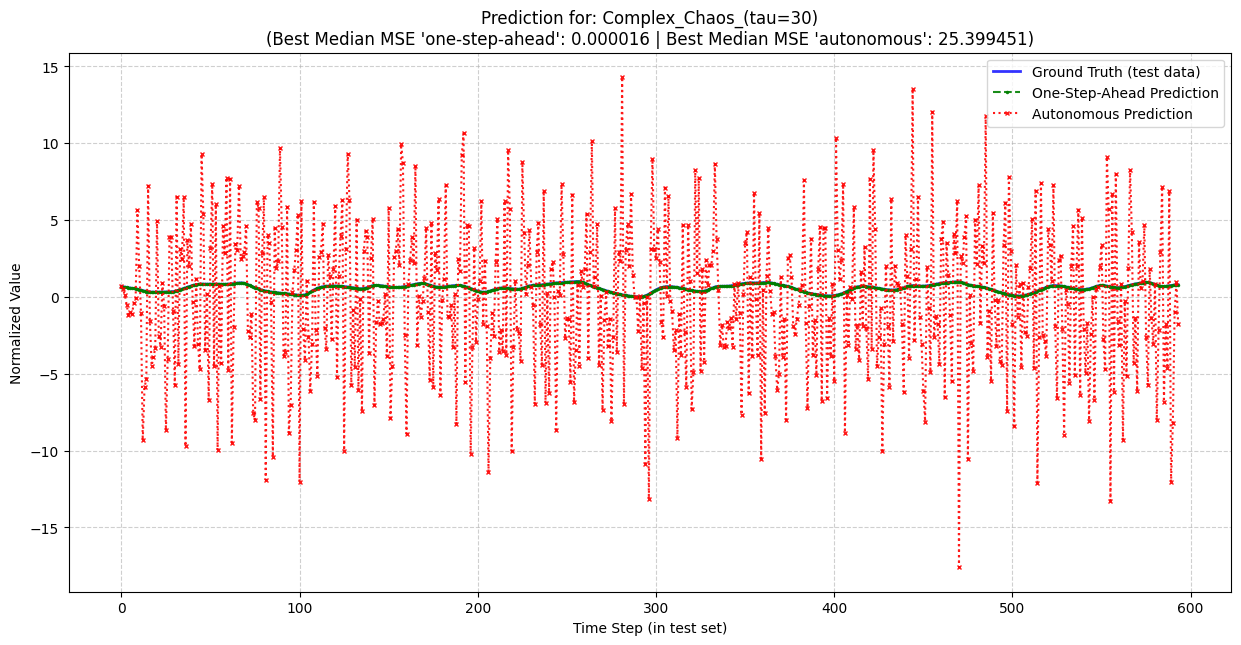


--- Generating plot for: Hyperchaotic_(tau=100) ---
Best parameters found: 
data_profile                 Hyperchaotic_(tau=100)
leakage_rate                                    0.9
lambda_reg                                      0.0
window_size                                       6
n_layers                                          2
lag                                               0
beta                                            0.2
gamma                                           0.1
n                                              10.0
tau                                           100.0
dt                                              1.0
T                                            2000.0
mean_mse_one_step_ahead                    0.000022
std_mse_one_step_ahead                     0.000003
min_mse_one_step_ahead                     0.000017
max_mse_one_step_ahead                     0.000027
median_mse_one_step_ahead                  0.000021
cv_mse_one_step_ahead                  

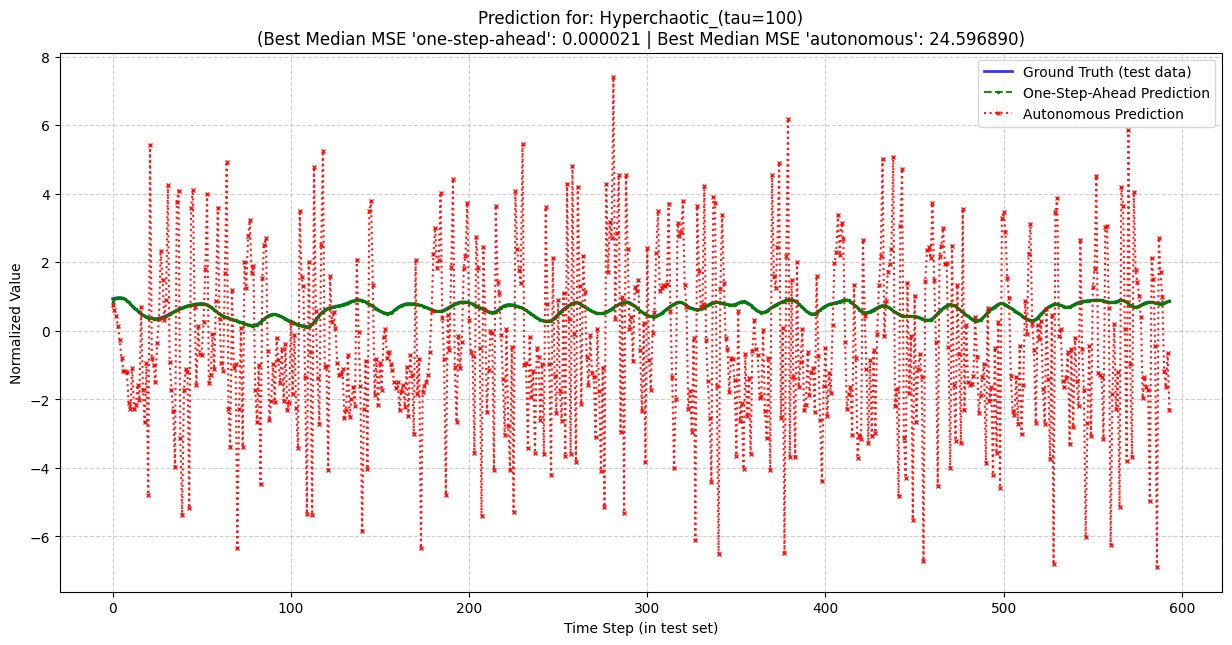


--- Generating plot for: NARMA10_Chaotic ---
Best parameters found: 
data_profile                 NARMA10_Chaotic
leakage_rate                             0.9
lambda_reg                               0.0
window_size                                6
n_layers                                   2
lag                                        0
beta                                     NaN
gamma                                    NaN
n                                        NaN
tau                                      NaN
dt                                       NaN
T                                        NaN
mean_mse_one_step_ahead             0.010672
std_mse_one_step_ahead              0.000062
min_mse_one_step_ahead              0.010562
max_mse_one_step_ahead              0.010769
median_mse_one_step_ahead           0.010681
cv_mse_one_step_ahead               0.005799
mean_mse_autonomous                 0.015536
std_mse_autonomous                  0.000249
min_mse_autonomous            

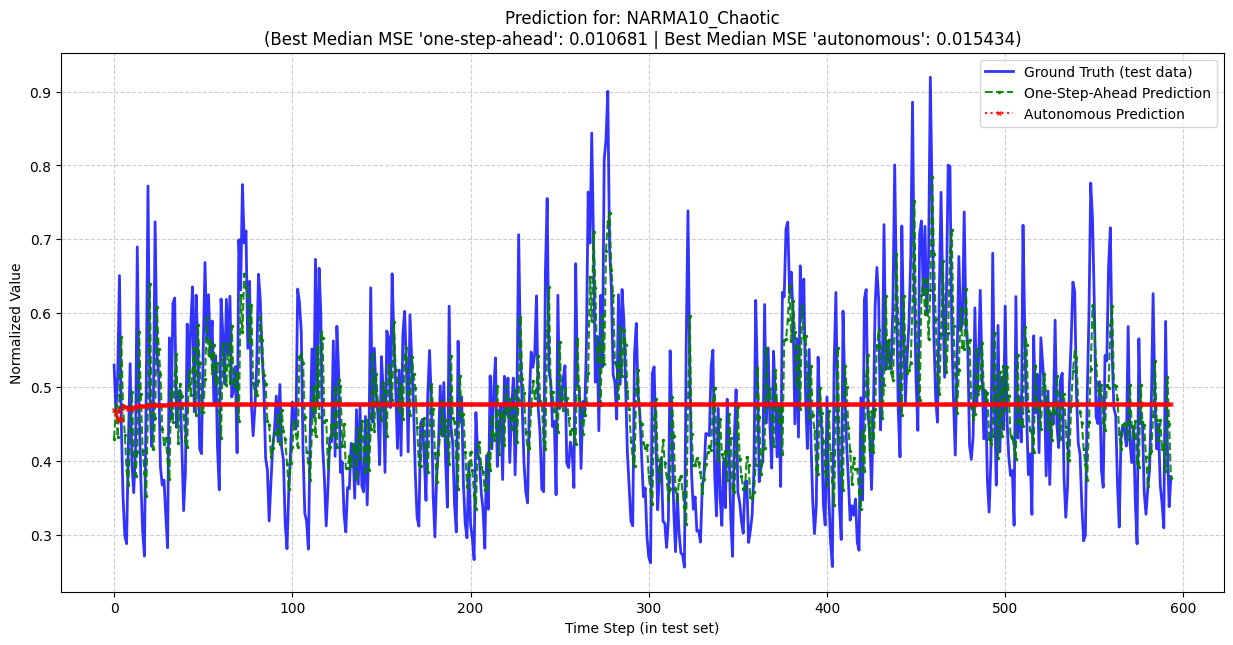

In [43]:
# === Step 8: Visualization of results for the best configuration ===

print("\nPreparing plots for the best configurations (based on autonomous prediction MSE)...")

# Check if there are any results to visualize
if not results_df.empty:
    # 1. Find the best parameters for each data profile based on the AUTONOMOUS prediction error
    best_results_per_profile = results_df.loc[results_df.groupby('data_profile')['median_mse_autonomous'].idxmin()]

    # 2. Loop through each of these best results to create a plot
    for index, best_params_row in best_results_per_profile.iterrows():
        best_params_dict = best_params_row.to_dict()
        profile_name = best_params_dict['data_profile']
        
        print(f"\n--- Generating plot for: {profile_name} ---")
        print(f"Best parameters found: \n{best_params_row.to_string()}")

        # ==========================================================
        # CORRECTION: Dynamically select the correct data generator
        # ==========================================================
        # Find the full profile dictionary for the current profile name
        current_profile = next((p for p in data_profiles if p['name'] == profile_name))
        # Get the correct generator function and its parameters
        generator_func = current_profile['generator']
        profile_gen_params = current_profile['params']
        # Call the correct generator dynamically
        time_series_for_best_model = generator_func(**profile_gen_params)
        # ==========================================================
        
        # 4. Prepare training and testing data
        best_win_size = int(best_params_dict['window_size'])
        best_n_qubits = best_win_size
        train_size_best = int(len(time_series_for_best_model) * train_fraction)
        
        train_inputs, train_outputs = create_io_pairs(time_series_for_best_model[:train_size_best], best_win_size)
        test_inputs, test_outputs = create_io_pairs(time_series_for_best_model[train_size_best:], best_win_size)

        # 5. Train the best model and perform BOTH predictions for a representative run
        W_out, weights, biases, _ = train_esn_reservoir(
            train_inputs, train_outputs,
            n_layers=int(best_params_dict['n_layers']),
            n_qubits=best_n_qubits,
            leakage_rate=best_params_dict['leakage_rate'],
            lambda_reg=best_params_dict['lambda_reg'],
            seed=seed
        )
        
        # One-step-ahead prediction
        one_step_preds = predict_esn(
            test_inputs, weights, biases, W_out, 
            int(best_params_dict['n_layers']), best_n_qubits, 
            best_params_dict['leakage_rate'], seed
        )
        
        # Autonomous prediction
        initial_window = train_inputs[-1]
        prediction_length = len(test_outputs)
        autonomous_preds = predict_esn_autonomous(
            initial_window, prediction_length, weights, biases, W_out, 
            int(best_params_dict['n_layers']), best_n_qubits, 
            best_params_dict['leakage_rate'], seed
        )

        # 6. Create a dedicated plot
        plt.figure(figsize=(15, 7))
        plt.plot(test_outputs, label="Ground Truth (test data)", color="blue", linewidth=2, alpha=0.8)
        plt.plot(one_step_preds, label="One-Step-Ahead Prediction", color="green", linestyle="--", marker='.', markersize=3, alpha=0.9)
        plt.plot(autonomous_preds, label="Autonomous Prediction", color="red", linestyle=":", marker='x', markersize=3, alpha=0.9)
        
        plt.xlabel("Time Step (in test set)")
        plt.ylabel("Normalized Value")
        
        median_mse_one_step_val = best_params_dict['median_mse_one_step_ahead']
        median_mse_auto_val = best_params_dict['median_mse_autonomous']
        plt.title(f"Prediction for: {profile_name}\n"
                  f"(Best Median MSE 'one-step-ahead': {median_mse_one_step_val:.6f} | "
                  f"Best Median MSE 'autonomous': {median_mse_auto_val:.6f})")
        
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

else:
    print("No results to visualize. Run the Grid Search first.")


Found 4 profiles to analyze: ['Complex_Chaos_(tau=30)', 'Hyperchaotic_(tau=100)', 'ARMA_1_2_stochastic', 'NARMA10_Chaotic']

--- Starting PCA analysis for profile: Complex_Chaos_(tau=30) ---

Best performing hyperparameters (one-step-ahead):
data_profile                 Complex_Chaos_(tau=30)
leakage_rate                                    0.9
lambda_reg                                      0.0
window_size                                      10
n_layers                                          2
lag                                               0
beta                                            0.2
gamma                                           0.1
n                                              10.0
tau                                            30.0
dt                                              1.0
T                                            2000.0
mean_mse_one_step_ahead                     0.00002
std_mse_one_step_ahead                     0.000015
min_mse_one_step_ahead       

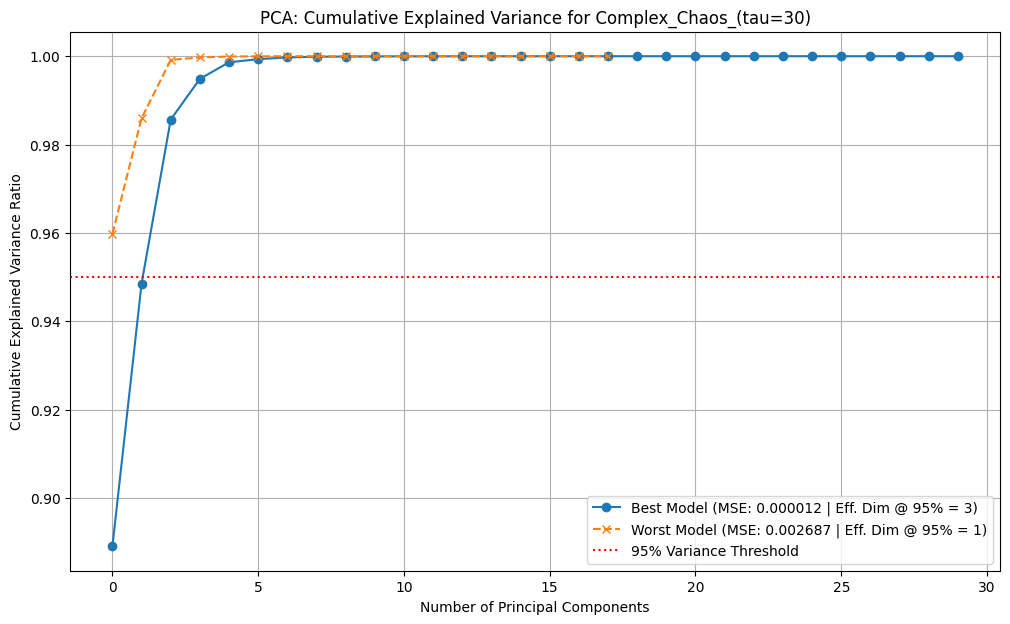


--- Starting PCA analysis for profile: Hyperchaotic_(tau=100) ---

Best performing hyperparameters (one-step-ahead):
data_profile                 Hyperchaotic_(tau=100)
leakage_rate                                    0.9
lambda_reg                                      0.0
window_size                                       6
n_layers                                          2
lag                                               0
beta                                            0.2
gamma                                           0.1
n                                              10.0
tau                                           100.0
dt                                              1.0
T                                            2000.0
mean_mse_one_step_ahead                    0.000022
std_mse_one_step_ahead                     0.000003
min_mse_one_step_ahead                     0.000017
max_mse_one_step_ahead                     0.000027
median_mse_one_step_ahead                  0.00002

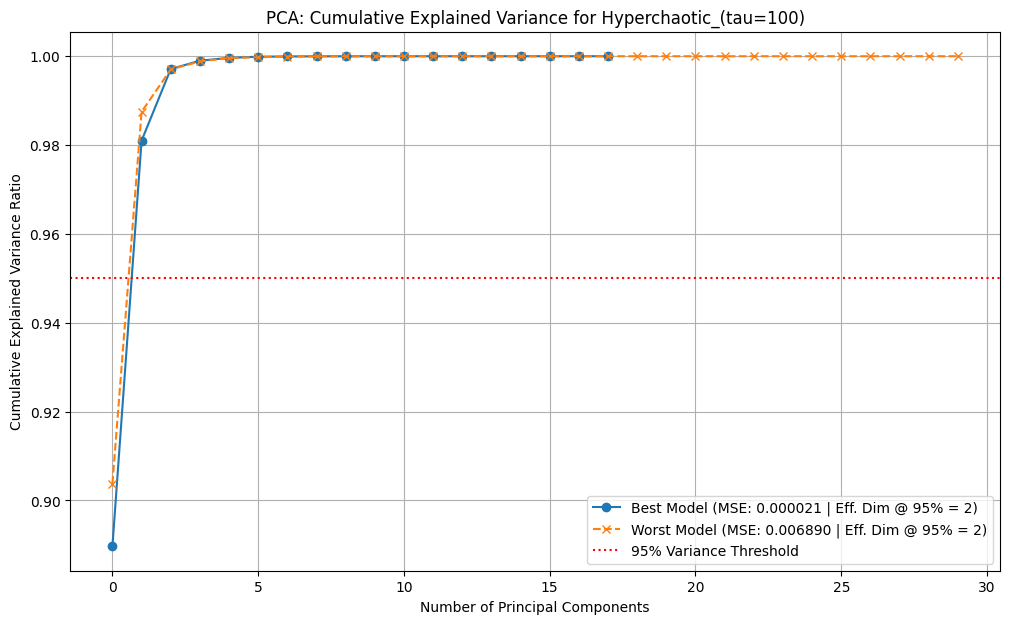


--- Starting PCA analysis for profile: ARMA_1_2_stochastic ---

Best performing hyperparameters (one-step-ahead):
data_profile                 ARMA_1_2_stochastic
leakage_rate                                 0.9
lambda_reg                                   0.0
window_size                                    6
n_layers                                       2
lag                                            0
beta                                         NaN
gamma                                        NaN
n                                            NaN
tau                                          NaN
dt                                           NaN
T                                            NaN
mean_mse_one_step_ahead                 0.008545
std_mse_one_step_ahead                  0.000113
min_mse_one_step_ahead                  0.008379
max_mse_one_step_ahead                  0.008693
median_mse_one_step_ahead               0.008506
cv_mse_one_step_ahead                   0.013206
mea

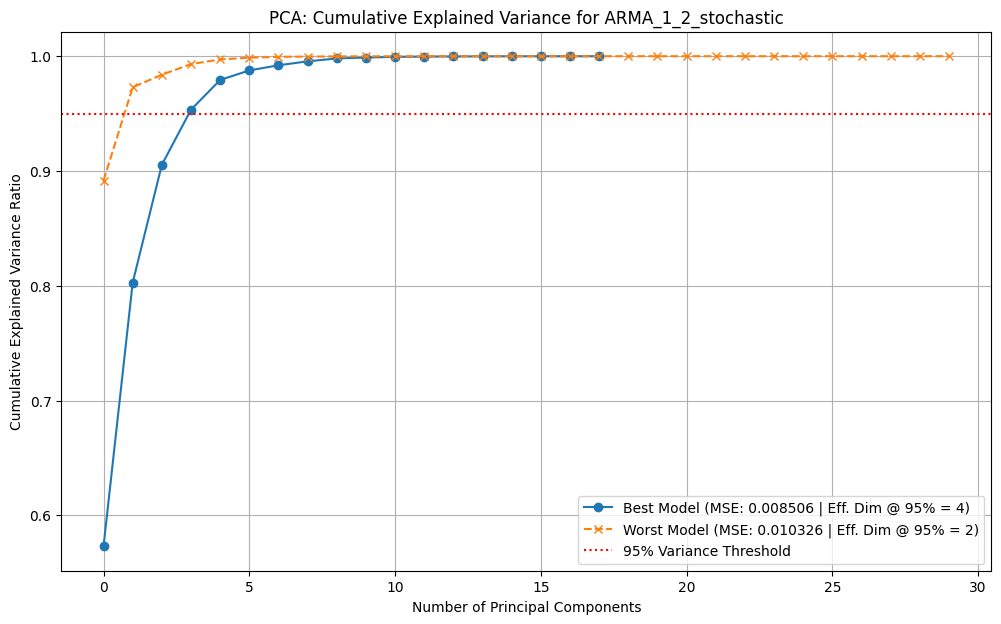


--- Starting PCA analysis for profile: NARMA10_Chaotic ---

Best performing hyperparameters (one-step-ahead):
data_profile                 NARMA10_Chaotic
leakage_rate                             0.9
lambda_reg                               0.0
window_size                               10
n_layers                                   3
lag                                        0
beta                                     NaN
gamma                                    NaN
n                                        NaN
tau                                      NaN
dt                                       NaN
T                                        NaN
mean_mse_one_step_ahead             0.008789
std_mse_one_step_ahead              0.000082
min_mse_one_step_ahead              0.008685
max_mse_one_step_ahead              0.008945
median_mse_one_step_ahead           0.008782
cv_mse_one_step_ahead               0.009372
mean_mse_autonomous                 0.016992
std_mse_autonomous                

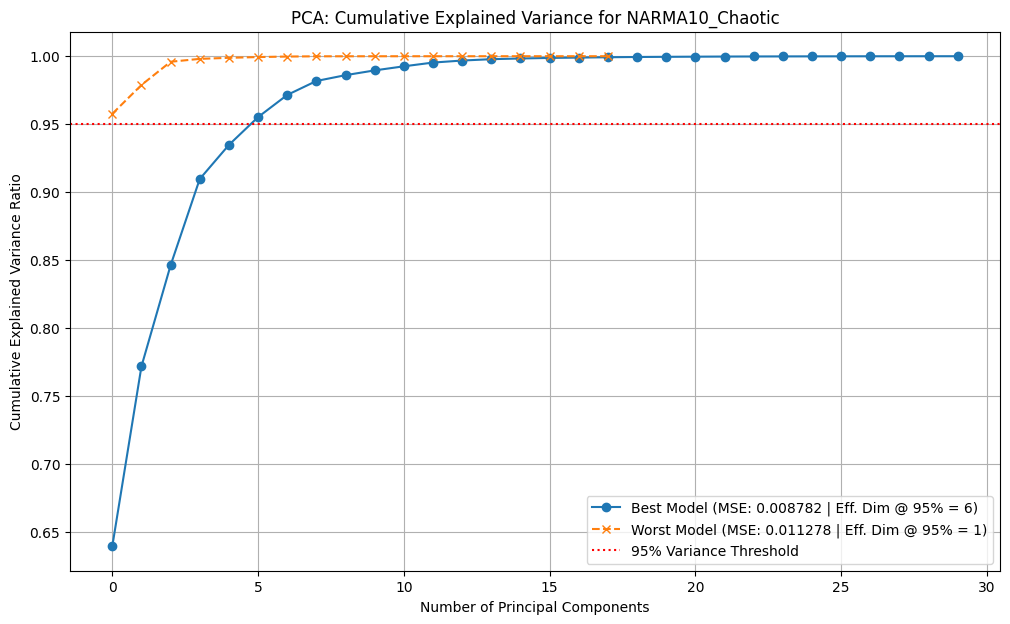

In [44]:
# === Step 9: Feature Space Analysis using PCA (Universal Version) ===
from sklearn.decomposition import PCA

# This helper function is already correct as it takes 'time_series' as an argument
def analyze_feature_space_pca(params, time_series, train_fraction, seed):
    """
    A helper function to run a single simulation and return the quantum features for PCA.
    """
    leakage, lambda_r, win_size, layers, lag = params
    n_qubits = win_size

    train_size = int(len(time_series) * train_fraction)
    train_inputs, train_outputs = create_io_pairs(time_series[:train_size], win_size)

    # We only need one representative run, so we use the main seed.
    # The fourth returned value (quantum_features) is what we need here.
    _, _, _, quantum_features = train_esn_reservoir(
        train_inputs, train_outputs, layers, n_qubits, leakage, lambda_r, seed
    )
    return quantum_features


# Load the results from our grid search
try:
    results_df = pd.read_csv('results_median_analysis.csv')
except FileNotFoundError:
    print("Error: The results file 'results_median_analysis.csv' was not found.")
    print("Please run the main research loop (Step 5) first.")
else:
    # Get a list of all unique data profiles that were processed in the experiment
    unique_profiles = results_df['data_profile'].unique()
    print(f"\nFound {len(unique_profiles)} profiles to analyze: {list(unique_profiles)}")

    # Loop over each unique profile found in the results file
    for current_profile_name in unique_profiles:
        profile_df = results_df[results_df['data_profile'] == current_profile_name]

        print(f"\n{'='*80}")
        print(f"--- Starting PCA analysis for profile: {current_profile_name} ---")
        print(f"{'='*80}")

        best_params_row = profile_df.loc[profile_df['median_mse_one_step_ahead'].idxmin()]
        worst_params_row = profile_df.loc[profile_df['median_mse_one_step_ahead'].idxmax()]

        print("\nBest performing hyperparameters (one-step-ahead):")
        print(best_params_row)
        print("\nWorst performing hyperparameters (one-step-ahead):")
        print(worst_params_row)

        # Dynamically select the correct data generator
        current_profile = next((p for p in data_profiles if p['name'] == current_profile_name))
        generator_func = current_profile['generator']
        profile_gen_params = current_profile['params']
        time_series = generator_func(**profile_gen_params)

        # Run PCA for the BEST model for this profile
        best_params_tuple = (
            best_params_row['leakage_rate'], best_params_row['lambda_reg'],
            int(best_params_row['window_size']),
            int(best_params_row['n_layers']), int(best_params_row['lag'])
        )
        features_best = analyze_feature_space_pca(best_params_tuple, time_series, train_fraction, seed)
        pca_best = PCA()
        pca_best.fit(features_best)
        cumulative_variance_best = np.cumsum(pca_best.explained_variance_ratio_)
        eff_dim_best = np.argmax(cumulative_variance_best >= 0.95) + 1

        # Run PCA for the WORST model for this profile
        worst_params_tuple = (
            worst_params_row['leakage_rate'], worst_params_row['lambda_reg'],
            int(worst_params_row['window_size']),
            int(worst_params_row['n_layers']), int(worst_params_row['lag'])
        )
        features_worst = analyze_feature_space_pca(worst_params_tuple, time_series, train_fraction, seed)
        pca_worst = PCA()
        pca_worst.fit(features_worst)
        cumulative_variance_worst = np.cumsum(pca_worst.explained_variance_ratio_)
        eff_dim_worst = np.argmax(cumulative_variance_worst >= 0.95) + 1

        # ===============================================================
        # NEW SECTION: Extract MSE values for the legend
        # ===============================================================
        best_mse = best_params_row['median_mse_one_step_ahead']
        worst_mse = worst_params_row['median_mse_one_step_ahead']

        # --Plot the results for this profile
        plt.figure(figsize=(12, 7))
        
        # ===============================================================
        # MODIFIED LEGEND: Add MSE values
        # ===============================================================
        plt.plot(cumulative_variance_best, marker='o', linestyle='-',
                 label=f'Best Model (MSE: {best_mse:.6f} | Eff. Dim @ 95% = {eff_dim_best})')
        plt.plot(cumulative_variance_worst, marker='x', linestyle='--',
                 label=f'Worst Model (MSE: {worst_mse:.6f} | Eff. Dim @ 95% = {eff_dim_worst})')

        plt.axhline(y=0.95, color='r', linestyle=':', label='95% Variance Threshold')
        plt.title(f'PCA: Cumulative Explained Variance for {current_profile_name}')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.grid(True)
        plt.legend()
        plt.show()